In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

import smfret.fit as fit

from smfret.tf_layers import Attention
from smfret.tf_layers import Conv
from smfret.tf_layers import Summary
from smfret.tf_layers import PrependTaskToken
from smfret.tf_layers import Embedding
from smfret.tf_layers import PositionEmbedding

import smfret.evaluation as evaluation

from smfret.trace_simulator import Simulator
from smfret.trace_simulator import ParameterGenerator
from smfret.trace_simulator import SimulatedTraceSet

from smfret.multi_task_learning import FRETStateTraceSet
from smfret.multi_task_learning import TwoStateQuickDynamicTraceSet
from smfret.multi_task_learning import SavedTraceSet
from smfret.dataset import MatlabTraceSet

from sklearn.manifold import TSNE
from sklearn import metrics

from sciplotlib import style as spstyle

In [2]:
trace_set = SavedTraceSet(file='saved_dataset/test/FRETSTATE_2STATE.npz', size=100)

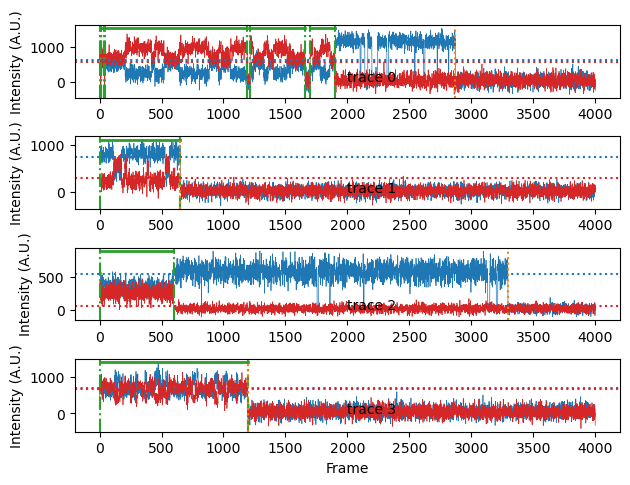

In [3]:
trace_set.plot_traces(n_start=0, n_traces=4)

In [4]:
ref_set = trace_set

In [5]:
def use_posterior(prob, max_marginal_prob=0.05):
    marginal_prob = np.mean(prob, axis=-2)
    marginal_prob[marginal_prob >= max_marginal_prob] = max_marginal_prob
    post_prob = np.einsum('itk,ik->itk', prob, marginal_prob)
    return post_prob

In [6]:
# linetime measurement

def lifetime(label):
    """Finds the lifetime according to the labeled states."""
    l = 0
    label = np.array(label)
    for i in range(len(label) - 1, 0, -1):
        if label[i] > 0:
            return i
    return 0

In [7]:
ref_set = SavedTraceSet(file='saved_dataset/test/FRETSTATE_2STATE.npz', size=2000)

In [8]:
# lifetime MAE

model = keras.models.load_model(f'saved_models/lstm-model-20240423-203825/FRETSTATE_2STATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})
# ideal_fret = tf.cast(tf.argmax(model.predict(ref_set.to_tensor()), axis=-1), tf.float32)
ideal_fret = tf.cast(tf.argmax(use_posterior(tf.math.softmax(model.predict(ref_set.to_tensor()), axis=-1)), axis=-1), tf.float32)
true_lifetime = []
predicted_lifetime = []
correct_state_count = []
high_fret_error = []
low_fret_error = []

for i in range(len(ref_set.traces)):
    true_lifetime.append(lifetime(ref_set.label[i, ...]))
    predicted_lifetime.append(lifetime(ideal_fret[i, ...]))
    correct_state_count.append(len(np.unique(ideal_fret[i, ...] // 2)) == 3)
    high_fret_error.append(np.max(ideal_fret[i, ...]) - np.max(ref_set.label[i, ...]))
    x, y = ideal_fret[i, ...], ref_set.label[i, ...]
    x, y = x[x>0], y[y>0]
    low_fret_error.append(np.min(x) - np.min(y))

print('MAE=', np.mean(np.abs(np.array(true_lifetime) - np.array(predicted_lifetime))))
print('State Count Accuracy =', np.mean(correct_state_count))
print('MAE High FRET=', FRETStateTraceSet.fret_states_resolution * np.mean(np.abs(high_fret_error)))
print('MAE Low FRET=', FRETStateTraceSet.fret_states_resolution * np.mean(np.abs(low_fret_error)))

63/63 [==============================] - 8s 90ms/step
MAE= 0.959
State Count Accuracy = 0.6825
MAE High FRET= 0.010225
MAE Low FRET= 0.00915


In [20]:
def convert_trace_to_tsv(trace, output_file):
    with open(output_file, 'w') as f:
        for d, a, l in zip(trace.donor, trace.acceptor, trace.label):
            if l > 0:
                f.write(f'{d}\t{a}\n')

In [22]:
for i in range(1000):
    convert_trace_to_tsv(ref_set.traces[i], f'/Users/leyou/Downloads/vbFRET_nov12-2/2_state_traces/trace_{i}.txt')

False


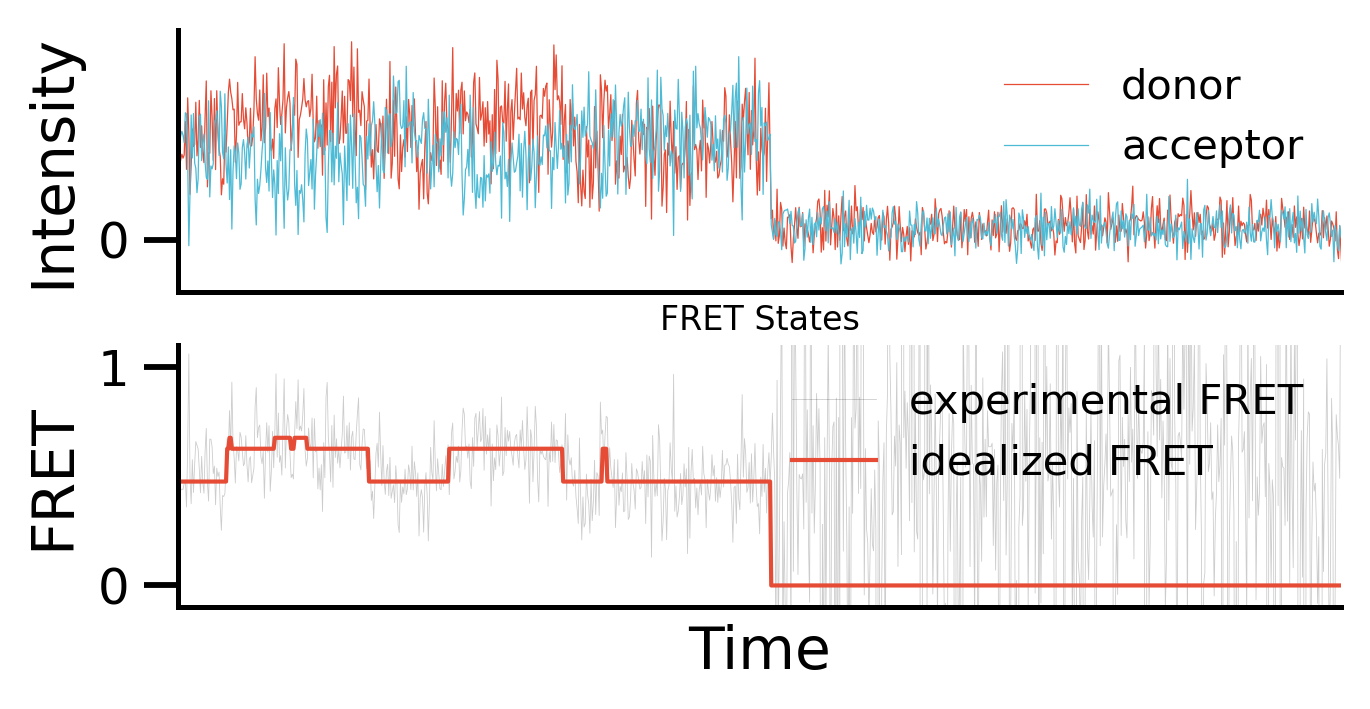

In [39]:
n = 470
with plt.style.context(spstyle.get_style('nature-reviews')):
    fig, axes = plt.subplots(2, 1, figsize=(5, 2.5))
    print(correct_state_count[n])
    ax=axes[0]
    ax.plot(ref_set.traces[n].acceptor , linewidth=0.3, label='donor')
    ax.plot(ref_set.traces[n].donor , linewidth=0.3, label='acceptor')
    ax.set_xticks([])
    ax.set_yticks([0])
    ax.set_ylabel('Intensity')
    # ax.set_xlabel('Time', fontsize=6, verticalalignment='top')
    ax.set_xlim([0, 1000])
    ax.legend()
    
    ax=axes[1]
    ax.plot(ref_set.traces[n].fret, linewidth=0.2, color='k', alpha=0.2, label='experimental FRET')
    ax.plot(np.maximum(ideal_fret[n, ...] - 0.5, 0) * FRETStateTraceSet.fret_states_resolution, linewidth=1, label='idealized FRET')
    # ax.tick_params(which='major', width=1.0, length=3, labelsize=10)
    # ax.tick_params(which='minor', width=1.0, length=2, labelsize=10,
               # labelcolor='0.25')
    plt.xticks([])
    plt.yticks([0, 1])
    ax.set_ylabel('FRET')
    ax.set_xlabel('Time')
    ax.set_xlim([0, 1000])
    plt.ylim(-0.1, 1.1)
    
    # ax.spines["top"].set_visible(True)
    # ax.spines["right"].set_visible(True)

    ax.legend()
    
    ax.set_title("FRET States", fontsize=8, verticalalignment='center')
    plt.savefig(f'figures/trace_example{n}.svg', transparent=True)
    plt.savefig(f'figures/trace_example{n}.png', transparent=True)

In [ ]:
## lifetime MAE

model = keras.models.load_model(f'saved_models/lstm-model-20240423-203825/FRETSTATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})
# ideal_fret = tf.cast(tf.argmax(model.predict(ref_set.to_tensor()), axis=-1), tf.float32)
ideal_fret = tf.cast(tf.argmax(use_posterior(tf.math.softmax(model.predict(ref_set.to_tensor()), axis=-1)), axis=-1), tf.float32)

true_lifetime = []
predicted_lifetime = []
correct_state_count = []
high_fret_error = []
low_fret_error = []

for i in range(len(ref_set.traces)):
    true_lifetime.append(lifetime(ref_set.label[i, ...]))
    predicted_lifetime.append(lifetime(ideal_fret[i, ...]))
    correct_state_count.append(len(np.unique(ideal_fret[i, ...] // 2)) == 3)
    high_fret_error.append(np.max(ideal_fret[i, ...]) - np.max(ref_set.label[i, ...]))
    x, y = ideal_fret[i, ...], ref_set.label[i, ...]
    x, y = x[x>0], y[y>0]
    low_fret_error.append(np.min(x) - np.min(y))

print('MAE=', np.mean(np.abs(np.array(true_lifetime) - np.array(predicted_lifetime))))
print('State Count Accuracy =', np.mean(correct_state_count))
print('MAE High FRET=', FRETStateTraceSet.fret_states_resolution * np.mean(np.abs(high_fret_error)))
print('MAE Low FRET=', FRETStateTraceSet.fret_states_resolution * np.mean(np.abs(low_fret_error)))

In [119]:
rng = np.random.default_rng()

def make_transition_prob_fn(k12, k21):
    counter = 0
    def transition_prob_fn():
        nonlocal counter
        counter += 1
        if counter % 2 == 0:
            return k12
        else:
            return k21
    return transition_prob_fn

def make_fret_value_fn(E1, E2):
    counter = 0
    def fret_value_fn():
        nonlocal counter
        counter += 1
        if counter % 2 == 0:
            return E2
        else:
            return E1
    return fret_value_fn

# uses default trace_length = 2000 
params_gen_base = ParameterGenerator(
    num_states_fn=lambda: 2,
    snr_signal_fn=lambda: rng.uniform(4, 12),
    snr_background_fn=lambda: rng.uniform(4, 12),
    transition_prob_fn=make_transition_prob_fn(0.06, 0.02),
    fret_states_fn=make_fret_value_fn(0.3, 0.7),
    donor_lifetime_fn=lambda: rng.uniform(low=1000, high=4000),
    trace_length_fn=lambda: 4000,
)

In [132]:
test_set = FRETStateTraceSet(size=1000, params_gen=params_gen_base)

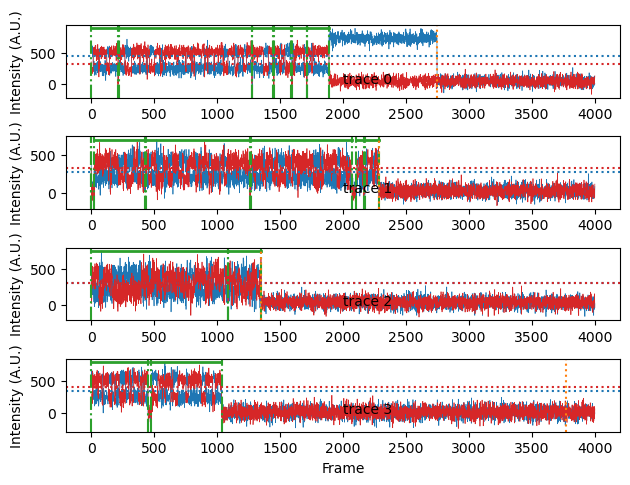

In [133]:
test_set.plot_traces(n_start=0, n_traces=4)

In [148]:
# lifetime MAE

model = keras.models.load_model(f'saved_models/lstm-model-20240423-203825/FRETSTATE_2STATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})
# ideal_fret = tf.cast(tf.argmax(model.predict(ref_set.to_tensor()), axis=-1), tf.float32)
ideal_fret = tf.cast(tf.argmax(use_posterior(tf.math.softmax(model.predict(test_set.to_tensor()), axis=-1)), axis=-1), tf.float32)

32/32 [==============================] - 8s 155ms/step


True


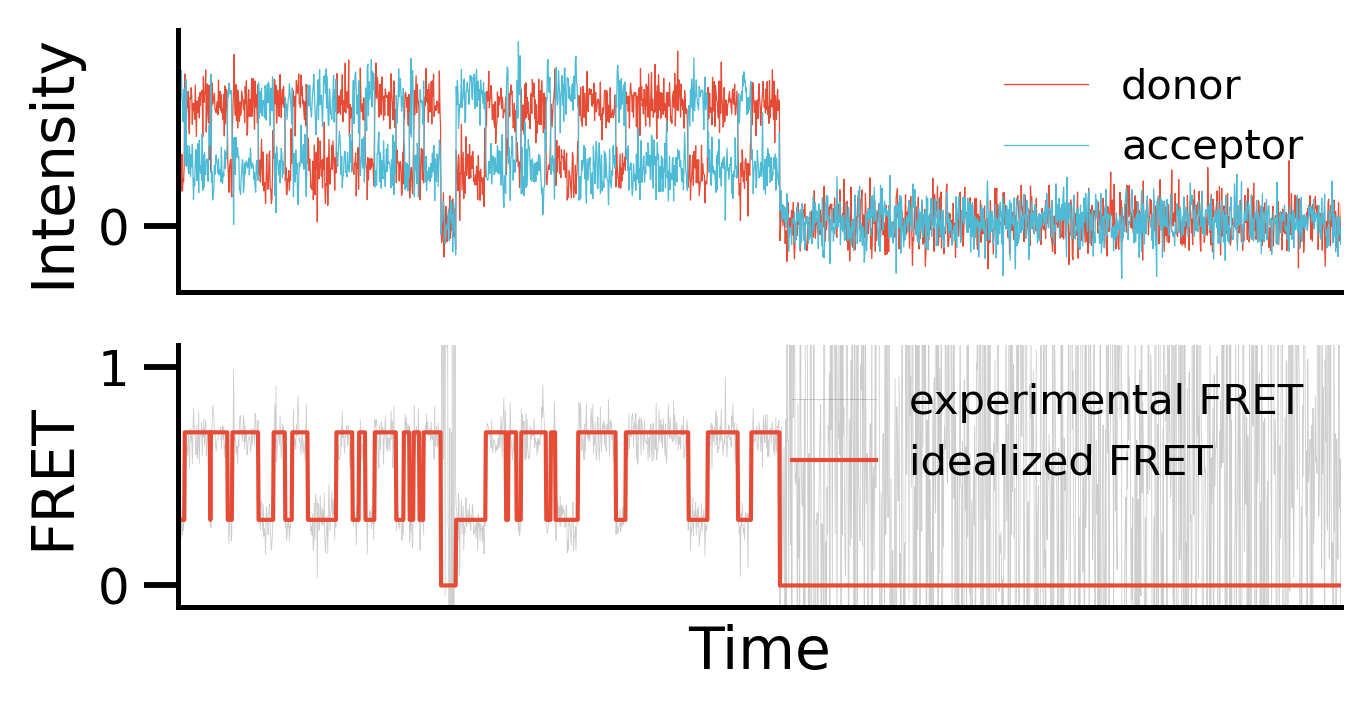

In [149]:
with plt.style.context(spstyle.get_style('nature-reviews')):
    fig, axes = plt.subplots(2, 1, figsize=(5, 2.5))
    n = 3
    print(correct_state_count[n])
    ax=axes[0]
    ax.plot(test_set.traces[n].acceptor , linewidth=0.3, label='donor')
    ax.plot(test_set.traces[n].donor , linewidth=0.3, label='acceptor')
    ax.set_xticks([])
    ax.set_yticks([0])
    ax.set_ylabel('Intensity')
    # ax.set_xlabel('Time', fontsize=6, verticalalignment='top')
    ax.set_xlim([0, 2000])
    ax.legend()
    
    ax=axes[1]
    ax.plot(test_set.traces[n].fret, linewidth=0.2, color='k', alpha=0.2, label='experimental FRET')
    ax.plot(np.maximum(ideal_fret[n, ...] // 2, 0) * FRETStateTraceSet.fret_states_resolution * 2, linewidth=1, label='idealized FRET')
    # ax.tick_params(which='major', width=1.0, length=3, labelsize=10)
    # ax.tick_params(which='minor', width=1.0, length=2, labelsize=10,
               # labelcolor='0.25')
    plt.xticks([])
    plt.yticks([0, 1])
    ax.set_ylabel('FRET')
    ax.set_xlabel('Time')
    ax.set_xlim([0, 2000])
    plt.ylim(-0.1, 1.1)
    
    # ax.spines["top"].set_visible(True)
    # ax.spines["right"].set_visible(True)

    ax.legend()
    
    # ax.set_title("FRET States", fontsize=8, verticalalignment='center')
    plt.savefig('figures/trace_2_state_with_fret.svg', transparent=True)
    plt.savefig('figures/trace_2_state_with_fret.png', transparent=True)

In [150]:
def get_fret_value(trace, states, target_state):
    """Calcualtes the mean FRET value."""
    return list(trace.fret[states == target_state])

In [151]:
def reject_outliers(data, m = 2.):
    """Reject outliner datapoints."""
    data = np.array(data)
    d = np.abs(data - np.mean(data))
    mean = np.median(d)
    s = d / mean if mean else np.zeros(len(d))
    return data[s<m]

In [157]:
FRET_zero_list = []
FRET_one_list = []

tau_one = []
tau_zero = []
FRET_zero = []
FRET_one = []

for i in range(test_set.size):
    pred_state = ideal_fret[i, :].numpy() // 2
    low_fret_state = np.quantile(pred_state[pred_state>0], 0.1)
    high_fret_state = np.quantile(pred_state[pred_state>0], 0.9)
    tau_zero += evaluation.get_dwell_time(states=pred_state, target_state=low_fret_state)
    tau_one += evaluation.get_dwell_time(states=pred_state, target_state=high_fret_state)
    FRET_zero += get_fret_value(test_set.traces[i], pred_state, target_state=low_fret_state)
    FRET_one += get_fret_value(test_set.traces[i], pred_state, target_state=high_fret_state)

bins = np.linspace(0, int(1.2 * np.max(tau_one + tau_zero)), 100)
time_resolution = 1
k_one_zero, k_one_zero_std = evaluation.estimate_k(tau_one, bins=bins, time_resolution=time_resolution, tau_min=2, return_fit_err=True)
k_zero_one, k_zero_one_std = evaluation.estimate_k(tau_zero, bins=bins, time_resolution=time_resolution, tau_min=2, return_fit_err=True)
FRET_zero_list.append(np.mean(reject_outliers(FRET_zero, m=6)))
FRET_one_list.append(np.mean(reject_outliers(FRET_one, m=6)))
print('k_{12} =', k_zero_one, 'k_{21} =', k_one_zero, '\n', 'FRET_1 =', FRET_zero_list[-1], 'FRET_2 =', FRET_one_list[-1])

k_{12} = 0.06096965395696953 k_{21} = 0.0200523229578301 
 FRET_1 = 0.3071316035690625 FRET_2 = 0.6859418083036477


In [162]:
(0.06096965395696953 - 0.06) / 0.06, (0.0200523229578301 - 0.02) / 0.02

(0.01616089928282554, 0.002616147891505022)

In [158]:
# lifetime MAE

model = keras.models.load_model(f'saved_models/lstm-model-20240423-203825/FRETSTATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})
# ideal_fret = tf.cast(tf.argmax(model.predict(ref_set.to_tensor()), axis=-1), tf.float32)
ideal_fret = tf.cast(tf.argmax(use_posterior(tf.math.softmax(model.predict(test_set.to_tensor()), axis=-1)), axis=-1), tf.float32)

32/32 [==============================] - 8s 154ms/step


In [159]:
FRET_zero_list = []
FRET_one_list = []

tau_one = []
tau_zero = []
FRET_zero = []
FRET_one = []

for i in range(test_set.size):
    pred_state = ideal_fret[i, :].numpy() // 2
    low_fret_state = np.quantile(pred_state[pred_state>0], 0.1)
    high_fret_state = np.quantile(pred_state[pred_state>0], 0.9)
    tau_zero += evaluation.get_dwell_time(states=pred_state, target_state=low_fret_state)
    tau_one += evaluation.get_dwell_time(states=pred_state, target_state=high_fret_state)
    FRET_zero += get_fret_value(test_set.traces[i], pred_state, target_state=low_fret_state)
    FRET_one += get_fret_value(test_set.traces[i], pred_state, target_state=high_fret_state)

bins = np.linspace(0, int(1.2 * np.max(tau_one + tau_zero)), 100)
time_resolution = 1
k_one_zero, k_one_zero_std = evaluation.estimate_k(tau_one, bins=bins, time_resolution=time_resolution, tau_min=2, return_fit_err=True)
k_zero_one, k_zero_one_std = evaluation.estimate_k(tau_zero, bins=bins, time_resolution=time_resolution, tau_min=2, return_fit_err=True)
FRET_zero_list.append(np.mean(reject_outliers(FRET_zero, m=6)))
FRET_one_list.append(np.mean(reject_outliers(FRET_one, m=6)))
print('k_{12} =', k_zero_one, 'k_{21} =', k_one_zero, '\n', 'FRET_1 =', FRET_zero_list[-1], 'FRET_2 =', FRET_one_list[-1])

k_{12} = 0.06133803737393534 k_{21} = 0.02014607318681152 
 FRET_1 = 0.3068675653091214 FRET_2 = 0.6859537352359092


In [163]:
(0.06133803737393534 - 0.06) / 0.06, (0.02014607318681152 - 0.02) / 0.02

(0.022300622898922356, 0.0073036593405760575)

In [215]:
np.quantile(test_set.fret.flat, 0.93)

1.2435887741533642

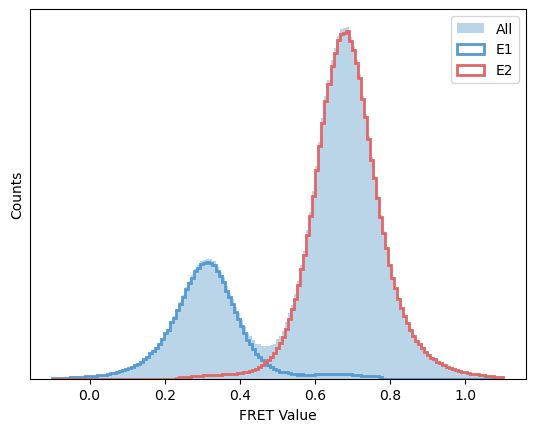

In [262]:
# with plt.style.context(spstyle.get_style('nature-reviews')):
fig, ax = plt.subplots(1, 1)
color[0], color[1] = '#559AD1', '#DF6767'
plt.hist(reject_outliers(np.concatenate([FRET_one, FRET_zero]), m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=0.3, edgecolor='none', label='All')

plt.hist(reject_outliers(FRET_zero, m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=1,histtype='step', linewidth=2, label='E1', color=color[0])
# plt.axvline(np.mean(reject_outliers(FRET_zero, m=8)), linewidth=1, linestyle=':')
plt.hist(reject_outliers(FRET_one, m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=1, histtype='step', linewidth=2, label='E2', color=color[1])
# plt.axvline(np.mean(reject_outliers(FRET_one, m=8)), linewidth=1, linestyle=':')
ax.set_yticks([])
ax.set_ylabel('Counts')
ax.set_xlabel('FRET Value')
ax.legend()
plt.savefig('figures/fret_hist_2_state.svg', transparent=True)
plt.savefig('figures/fret_hist_2_state.png', transparent=True)

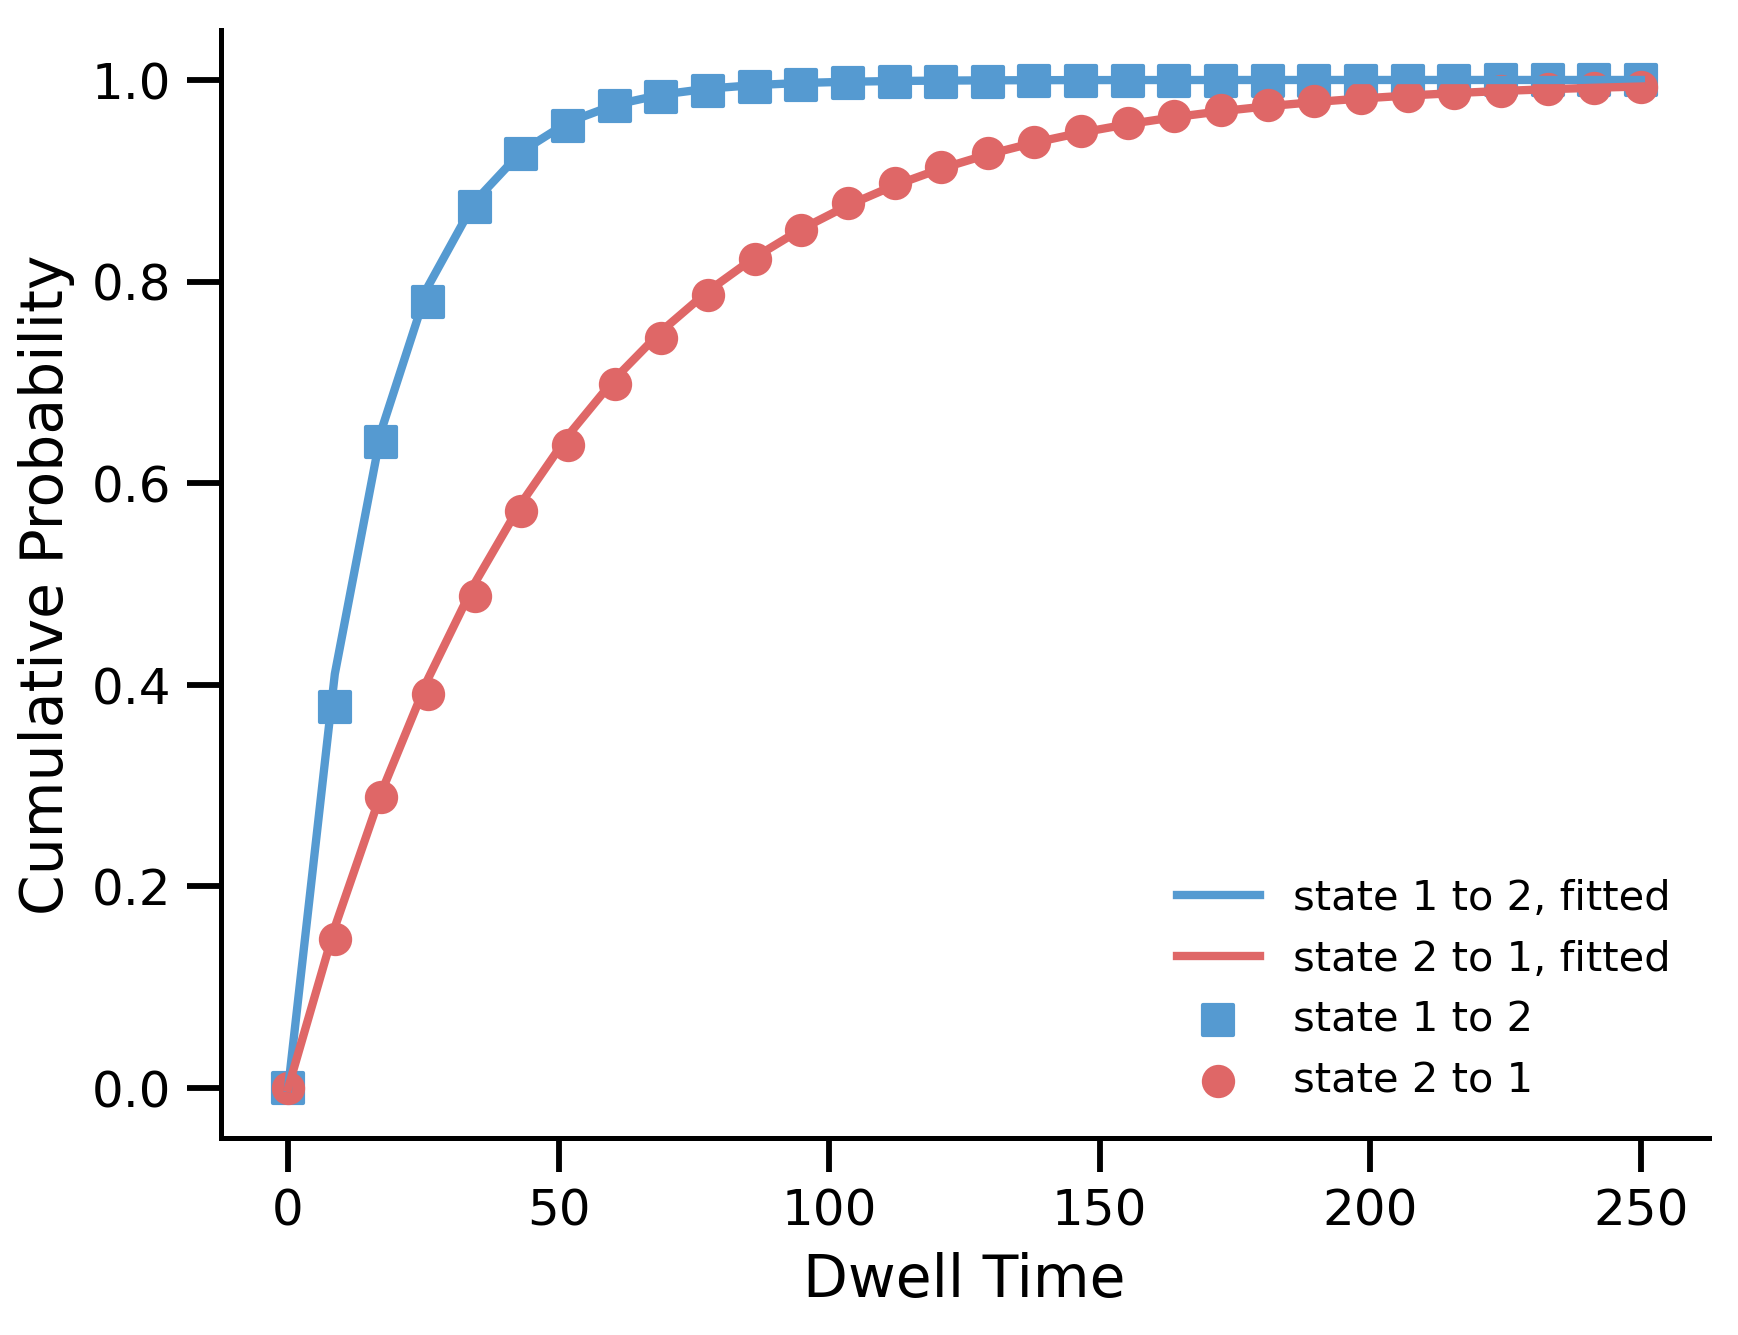

In [256]:
bins = np.linspace(0, 250, 30)
b = 5
with plt.style.context(spstyle.get_style('nature-reviews')):
    # plt.figure(figsize=(8, 6))
    color = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color[0], color[1] = '#559AD1', '#DF6767'
    plt.scatter(bins * time_resolution, evaluation.get_cdf([x - b for x in tau_zero if x > b], bins=bins), color=color[0], marker='s', label='state 1 to 2')
    plt.plot(bins * time_resolution, 1 - np.exp(- k_zero_one * time_resolution * bins), color=color[0], label='state 1 to 2, fitted')
    plt.scatter(bins * time_resolution, evaluation.get_cdf([x - b for x in tau_one if x > b], bins=bins), color=color[1], label='state 2 to 1')
    plt.plot(bins * time_resolution, 1 - np.exp(- k_one_zero * time_resolution * bins), color=color[1], label='state 2 to 1, fitted')
    plt.xlabel('Dwell Time')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.savefig('figures/dwell-time-cumulative-prob-fit.svg', transparent=True, dpi=120)